## Radio Deconvolution Playground

Exploring radio inspired deconvolution techniques for JWST images

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits


nice_fonts = {
    "text.usetex": True,
    "font.family": "serif",
    "text.latex.preamble" : r'\usepackage{amssymb} \usepackage{amsmath}',
}

plt.rcParams.update(nice_fonts)

def add_colorbar(mappable, label=None):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    import warnings
    warnings.filterwarnings("ignore")
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    cbar.ax.set_yticklabels(["{:.3f}".format(i) for i in cbar.get_ticks()])
    cbar.set_label(label)
    plt.sca(last_axes)
    return cbar

In [2]:
# https://stackoverflow.com/questions/28342968/how-to-plot-a-2d-gaussian-with-different-sigma

def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos."""

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

### Generate a Gaussian Kernel (PSF)

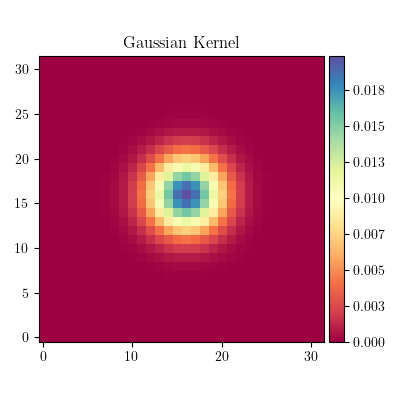

In [3]:
# Our 2-dimensional distribution will be over variables X and Y
N = 32
X = np.arange(N)
Y = np.arange(N)
X, Y = np.meshgrid(X, Y)

# Mean vector and covariance matrix
mu = np.array([16, 16])
Sigma = np.array([[ 8 , 0], [0,  8]])

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

# The distribution on the variables X, Y packed into pos.
kernel = multivariate_gaussian(pos, mu, Sigma)

%matplotlib widget
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

im = ax.imshow(kernel, origin='lower', cmap='Spectral')

ax.set_title('Gaussian Kernel')
ax.set_aspect('equal')

add_colorbar(im)

plt.tight_layout()
plt.show()

### Make a fake sky with a couple of square sources

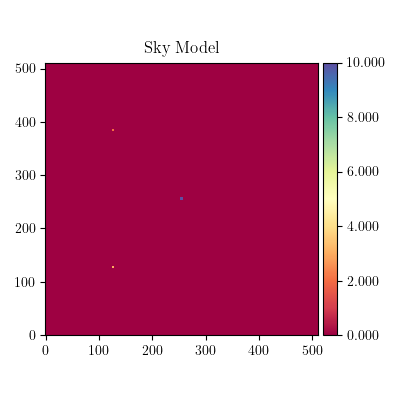

In [4]:
# Empty sky
sky = np.zeros((512, 512))

# Stars will be 4x4 squares
sky[256-2:256+2, 256-2:256+2] += 10
sky[128-2:128+2, 128-2:128+2] += 3
sky[384-2:384+2, 128-2:128+2] += 2

%matplotlib widget
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

im = ax.imshow(sky, origin='lower', cmap='Spectral', interpolation='none')

ax.set_title('Sky Model')
ax.set_aspect('equal')

add_colorbar(im)

plt.tight_layout()
plt.show()

### Zero padding

In [5]:
# define zero padding stuff
# https://stackoverflow.com/questions/38191855/zero-pad-numpy-array

def zero_pad(img, ker):
    """Zero pad kernel to shape of img"""
    img_dim = img.shape[0]
    ker_dim = ker.shape[0]

    pad_width = int((img_dim - ker_dim)/2)
    
    # ((top, bottom), (left, right))
    return np.pad(ker, ((pad_width,pad_width),(pad_width,pad_width)), 'constant', constant_values=0)

### Convolve sky model with kernel

In [6]:
sky_ft = np.fft.fftshift(np.fft.fft2(sky))
ker_pad = zero_pad(sky, kernel)
ker_ft = np.fft.fftshift(np.fft.fft2(ker_pad))

# ker_ft = np.fft.fftshift(np.fft.fft2(kernel))
# ker_ft_pad = zero_pad(sky_ft, ker_ft)

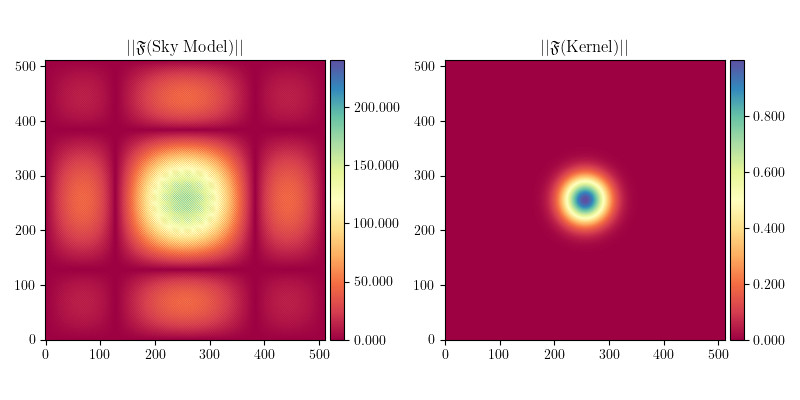

In [7]:
%matplotlib widget
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

im1 = ax1.imshow(np.abs(sky_ft), origin='lower', cmap='Spectral')
add_colorbar(im1)
im2 = ax2.imshow(np.abs(ker_ft), origin='lower', cmap='Spectral')
add_colorbar(im2)

ax1.set_title('$||\mathfrak{F}$(Sky Model)$||$')
ax2.set_title('$||\mathfrak{F}$(Kernel)$||$')

plt.tight_layout()
plt.show()

In [8]:
sky_conv_ft = sky_ft * ker_ft
sky_conv = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(sky_conv_ft)))

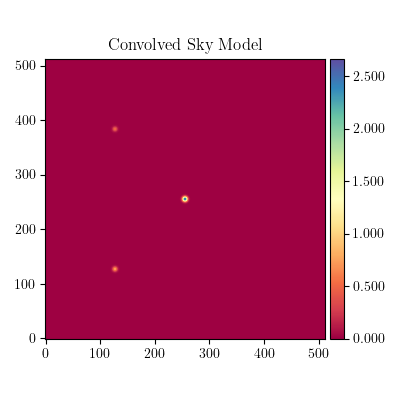

In [9]:
%matplotlib widget
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

im = ax.imshow(np.abs(sky_conv), origin='lower', cmap='Spectral')

ax.set_title('Convolved Sky Model')
ax.set_aspect('equal')

add_colorbar(im)

plt.tight_layout()
plt.show()

### Try and deconvolve this

In [10]:
sky_conv_ft = np.fft.fftshift(np.fft.fft2(sky_conv))
sky_deconv = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(sky_conv_ft / ker_ft)))

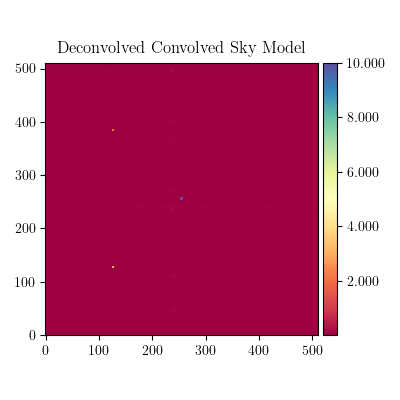

In [11]:
%matplotlib widget
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

im = ax.imshow(np.abs(sky_deconv), origin='lower', cmap='Spectral', interpolation='none')

ax.set_title('Deconvolved Convolved Sky Model')
ax.set_aspect('equal')

add_colorbar(im)

plt.tight_layout()
plt.show()

### Look at the residuals b/w original Sky Model & Deconvolved "Convolved" Sky Model

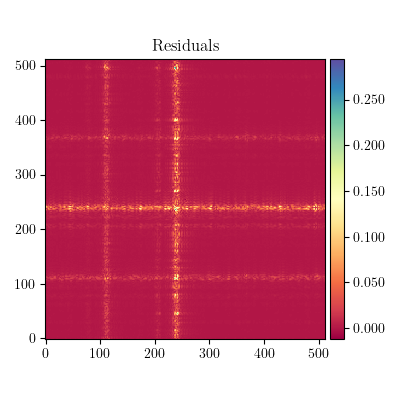

In [12]:
%matplotlib widget
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

im = ax.imshow(np.abs(sky_deconv) - sky, origin='lower', cmap='Spectral', interpolation='none')

ax.set_title('Residuals')
ax.set_aspect('equal')

add_colorbar(im)

plt.tight_layout()
plt.show()

## WARNING! This simple deconvolution can cause a *NOISE EXPLOSION*

This basic Fourier deconvolution works by dividing the fourier transform of the Image, but the fourier transform of the PSF. Note that the Fourier PSF, far from the center (at small, and thus noise-like, scales) can be small. Dividing by a small number will lead to the amplification of noise at these small scales!!

### Lets look at a more complex example

In [13]:
def convolve(sky, ker):
    sky_ft = np.fft.fftshift(np.fft.fft2(sky))
    ker_pad = zero_pad(sky, ker)
    ker_ft = np.fft.fftshift(np.fft.fft2(ker_pad))
    sky_conv_ft = sky_ft * ker_ft
    sky_conv = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(sky_conv_ft)))

    return sky_conv

In [14]:
def deconvolve(sky_conv, ker):
    sky_conv_ft = np.fft.fftshift(np.fft.fft2(sky_conv))
    ker_pad = zero_pad(sky_conv, ker)
    ker_ft = np.fft.fftshift(np.fft.fft2(ker_pad))
    sky_deconv = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(sky_conv_ft / ker_ft)))

    return sky_deconv

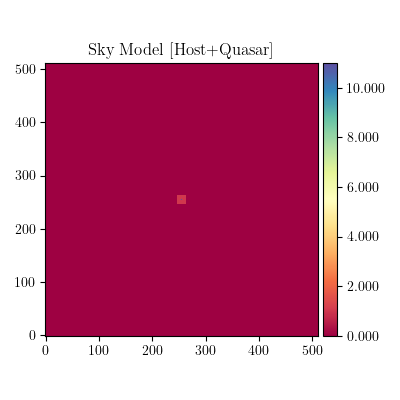

In [15]:
# Empty sky
sky = np.zeros((512, 512))

# Host galaxy 16x16 square
sky[256-8:256+8, 256-8:256+8] += 1
sky[256-1:256+1, 256-1:256+1] += 10

%matplotlib widget
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

im = ax.imshow(sky, origin='lower', cmap='Spectral', interpolation='none')

ax.set_title('Sky Model [Host+Quasar]')
ax.set_aspect('equal')

add_colorbar(im)

plt.tight_layout()
plt.show()

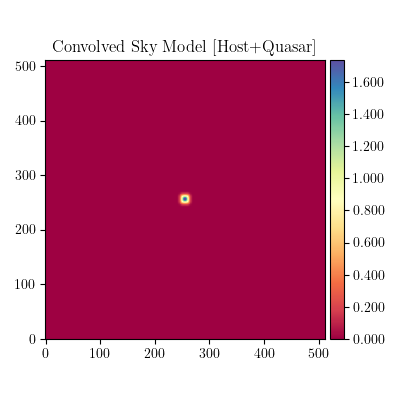

In [16]:
sky_conv = convolve(sky, kernel)

%matplotlib widget
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

im = ax.imshow(np.abs(sky_conv), origin='lower', cmap='Spectral', interpolation='none')

ax.set_title('Convolved Sky Model [Host+Quasar]')
ax.set_aspect('equal')

add_colorbar(im)

plt.tight_layout()
plt.show()

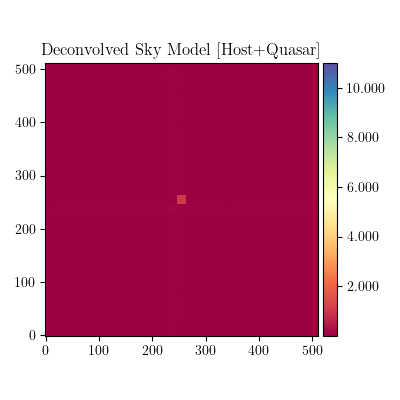

In [17]:
sky_deconv = deconvolve(sky_conv, kernel)

%matplotlib widget
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

im = ax.imshow(np.abs(sky_deconv), origin='lower', cmap='Spectral', interpolation='none')

ax.set_title('Deconvolved Sky Model [Host+Quasar]')
ax.set_aspect('equal')

add_colorbar(im)

plt.tight_layout()
plt.show()

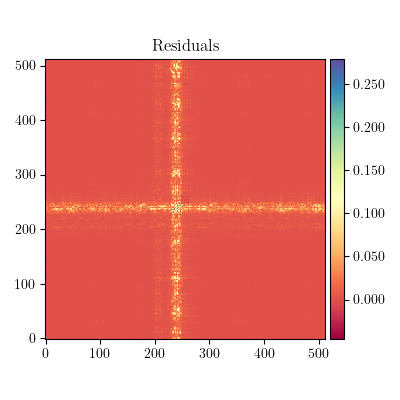

In [18]:
%matplotlib widget
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

im = ax.imshow(np.abs(sky_deconv) - sky, origin='lower', cmap='Spectral', interpolation='none')

ax.set_title('Residuals')
ax.set_aspect('equal')

add_colorbar(im)

plt.tight_layout()
plt.show()